# get Na halides crystal info

In [31]:

from mp_api.client import MPRester
import pymatgen
import pandas as pd
import json
import os
import requests
import numpy as np   
from pymatgen.core.structure import Structure    
from pymatgen.io.cif import CifWriter
import torch
#from torch_geometric.data import Data
from torch.utils.data import DataLoader
# convert data to pandas data
# frame and store it in .csv file
# unit_cell_formula.Li可以只得到unit_cell_formula字典中Li对应的学习



In [33]:
m = MPRester('YOUR KEY')

anion=["F","Cl","Br","I"]
data_s=[]
for halide in anion:
    data_s = m.summary.search(elements=["Li",halide],num_elements=3,
                             
                              fields=["structure","material_id","formula_pretty","is_stable"] 
                                      )+data_s

c:\Users\nxldz\anaconda3\envs\DL4MS\lib\site-packages\mp_api\client\mprester.py:182: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/965 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/70 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/55 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/37 [00:00<?, ?it/s]

In [34]:
def pdf(crystal,cutoff=40):
    pair_info=[]
    pair_info_length=[]
    all_atoms=crystal.atomic_numbers

    all_nbrs = crystal.get_all_neighbors(cutoff, include_index=True)
    all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
    element_onehot = np.eye(112, 112)


    for i in range(len(all_atoms)):
        for n in range(i,len(all_atoms)):
            node=np.concatenate([element_onehot[all_atoms[i]],element_onehot[all_atoms[n]]],axis=0)
            #print('node:',len(node))
            distance = [round(1/nbr[1],5)  for nbr in all_nbrs[i] if nbr.index==n]
            distance=list(set(distance))
            if len(distance)>=100:
                distance_new=distance[:100]
            #only save the shorest 100 distances
            else:
                distance_new=np.pad(distance,( (0,100-len(distance))), mode='constant', constant_values=0)
            #if distance numbers are less than 100, padding 0 to the rest

            pair_info_=np.concatenate([node,distance_new],axis=0)

            pair_info.append(pair_info_)
            pair_info_length.append(pair_info_.shape[0])


    pair_info_new=np.array([np.pad(pair_info_,( (0,max(pair_info_length)-len(pair_info_))), mode='constant', constant_values=0) for pair_info_ in pair_info])





    return  pair_info_new 

In [35]:
mat_id,fea,label=[],[],[]
node_num=[]

for data in data_s:
    
    structure=data.structure
    if len(structure.atomic_numbers)<=20:
      #only atom number is less than 20, the crystal will be counted in case of out of memory
      x=pdf(structure,20)
      mat_id.append(data.material_id)
    
    
      node_num.append(len(x))
      fea.append(x)
      
      
      if data.is_stable==1:
          label.append([1])
      else:
          label.append([0])
    
      if len(label)%100==0:
        print(len(label))




100
200
300
400
500


In [36]:
def convert_to_list(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        return [convert_to_list(item) for item in value]
    else:
        return value

In [37]:
import json



my_dict = {
    'mp_id': mat_id,
    'fea': convert_to_list(fea),
    'stability': label
}


file_name = "Li_Na_halide_data_stable.json"

with open(file_name, 'w') as json_file:
    json.dump(my_dict, json_file)
#you can also save data in json for next use

In [38]:
from sklearn.model_selection import train_test_split
def split(x,y,n):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=n,random_state=0)    
    return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=split(fea,label,0.3)


# generate dataset

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class VariableLengthDataset(Dataset):
    def __init__(self, data_list, labels):
        self.data_list = data_list
        self.labels = labels

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        data = torch.tensor(self.data_list[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return data, label

def collate_fn(batch):
    # Custom collate function to handle variable-length sequences
    data, labels = zip(*batch)

    # Pad sequences to the maximum length in the batch
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)

    return padded_data, torch.tensor(labels, dtype=torch.long)

custom_dataset = VariableLengthDataset(x_train, y_train)

batch_size = 20
dataloader = DataLoader(custom_dataset, batch_size=batch_size, collate_fn=collate_fn)

for batch_data, batch_labels in dataloader:
    # Your training or evaluation logic here
    print("Train Batch Data:", batch_data.shape)
    #print("Train Batch Labels:", batch_labels)


Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([20, 210, 324])
Train Batch Data: torch.Size([13, 136, 324])


In [40]:

custom_dataset_test = VariableLengthDataset(x_test, y_test)

batch_size = 20
dataloader_test = DataLoader(custom_dataset_test, batch_size=batch_size, collate_fn=collate_fn)

for batch_data, batch_labels in dataloader_test:
    # Your training or evaluation logic here
    print("Test Batch Data:", batch_data.shape)
    #print("Test Batch Labels:", batch_labels)


Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([20, 210, 324])
Test Batch Data: torch.Size([17, 210, 324])


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.linear1 = nn.Linear(324, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
       
        x=torch.sum(x,dim=1)
        
        x = self.sigmoid(x)
        return x


# Initialize model, loss, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
all_losses=[]
# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        batch_loss=[]
        optimizer.zero_grad()
        outputs = model(batch_data)  # Add channel dimension
        #_, predicted = torch.max(outputs, 1)
        #print(outputs)
        #print(batch_labels)
        loss = criterion(outputs.to(dtype=float), batch_labels.view(-1,1).to(dtype=float))
        binary_predictions = (outputs >= 0.5).float()
        accuracy = torch.sum(binary_predictions == torch.Tensor(batch_labels).view(-1, 1)).item() / len(batch_labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    all_losses.append(sum(batch_loss)/len(batch_loss))
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {sum(batch_loss)/len(batch_loss):.4f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Accurancy: {accuracy}')

# Now, your model is trained. You can use it for predictions.


Epoch [10/200], Loss: 0.1907
Epoch [10/200], Accurancy: 1.0
Epoch [20/200], Loss: 0.1148
Epoch [20/200], Accurancy: 1.0
Epoch [30/200], Loss: 0.1158
Epoch [30/200], Accurancy: 1.0
Epoch [40/200], Loss: 0.0898
Epoch [40/200], Accurancy: 1.0
Epoch [50/200], Loss: 0.0661
Epoch [50/200], Accurancy: 1.0
Epoch [60/200], Loss: 0.0483
Epoch [60/200], Accurancy: 1.0
Epoch [70/200], Loss: 0.0389
Epoch [70/200], Accurancy: 1.0
Epoch [80/200], Loss: 0.0267
Epoch [80/200], Accurancy: 1.0
Epoch [90/200], Loss: 0.0231
Epoch [90/200], Accurancy: 1.0
Epoch [100/200], Loss: 0.0170
Epoch [100/200], Accurancy: 1.0
Epoch [110/200], Loss: 0.0076
Epoch [110/200], Accurancy: 1.0
Epoch [120/200], Loss: 0.0051
Epoch [120/200], Accurancy: 1.0
Epoch [130/200], Loss: 0.0049
Epoch [130/200], Accurancy: 1.0
Epoch [140/200], Loss: 0.0032
Epoch [140/200], Accurancy: 1.0
Epoch [150/200], Loss: 0.0026
Epoch [150/200], Accurancy: 1.0
Epoch [160/200], Loss: 0.0014
Epoch [160/200], Accurancy: 1.0
Epoch [170/200], Loss: 0.0

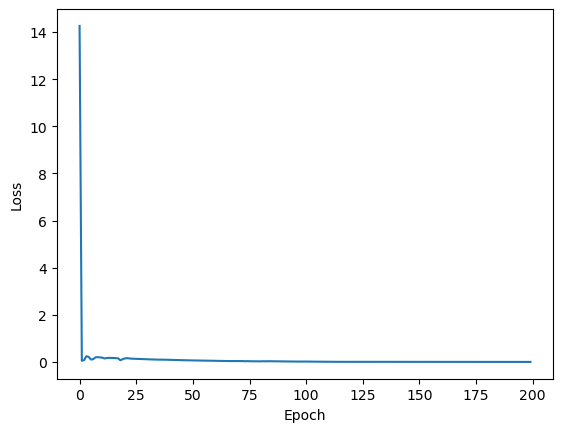

In [48]:
import matplotlib.pyplot as plt
#print(all_loss)
plt.plot(range(num_epochs), all_losses )
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

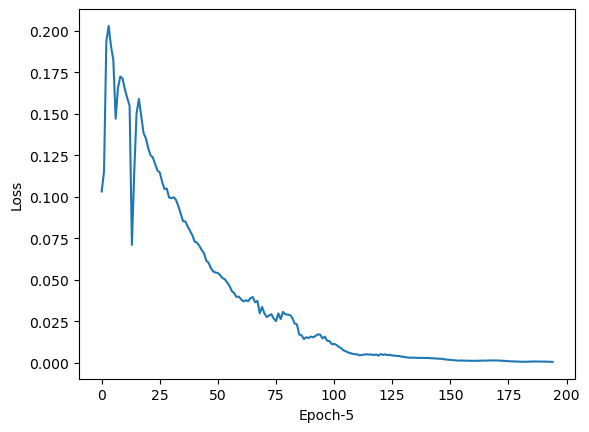

In [52]:
import matplotlib.pyplot as plt
#print(all_loss)
plt.plot(range(num_epochs-5), all_losses[5:] )
plt.xlabel('Epoch-5')
plt.ylabel('Loss')

plt.show()

In [49]:
def test_model(model, dataloader):
    with torch.no_grad():
        model.eval()

        for batch in dataloader:
            
            batch_data, batch_labels = batch

           

            
            predictions = model(batch_data)
            
            binary_predictions = (predictions >= 0.5).float()
            

            #print(binary_predictions.view(1,-1))
            #print(batch_labels)
         


            
            accuracy = torch.sum(binary_predictions == torch.Tensor(batch_labels).view(-1, 1)).item() / len(batch_labels)
            if (torch.Tensor(batch_labels).view(-1, 1)==1).sum().item()!=0:
                
                recall_rate= ((binary_predictions == 1) & (torch.Tensor(batch_labels).view(-1, 1)==1)).sum().item() / (torch.Tensor(batch_labels).view(-1, 1)==1).sum().item()
                print(f"  Batch Recall rate: {recall_rate:.4f}")
            print(f"Batch Test Accuracy: {accuracy:.4f}")
            


test_model(model, dataloader_test)

  Batch Recall rate: 0.0000
Batch Test Accuracy: 0.9500
  Batch Recall rate: 0.2500
Batch Test Accuracy: 0.8500
  Batch Recall rate: 0.0000
Batch Test Accuracy: 0.9000
  Batch Recall rate: 0.0000
Batch Test Accuracy: 0.7500
  Batch Recall rate: 1.0000
Batch Test Accuracy: 1.0000
  Batch Recall rate: 0.5000
Batch Test Accuracy: 0.9000
  Batch Recall rate: 0.0000
Batch Test Accuracy: 0.8000
  Batch Recall rate: 0.0000
Batch Test Accuracy: 0.8500
Batch Test Accuracy: 1.0000
